In [1]:
library(tidyverse)
library(magrittr)
source("../data/env/variables.R")
source("../wisdom/code/r/clean_theme.R")

options("readr.num_columns" = 0)

# read switches
switches <- read_tsv("../data/pancancer/candidateList_full.tsv")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



# Stoma/immune associated switches

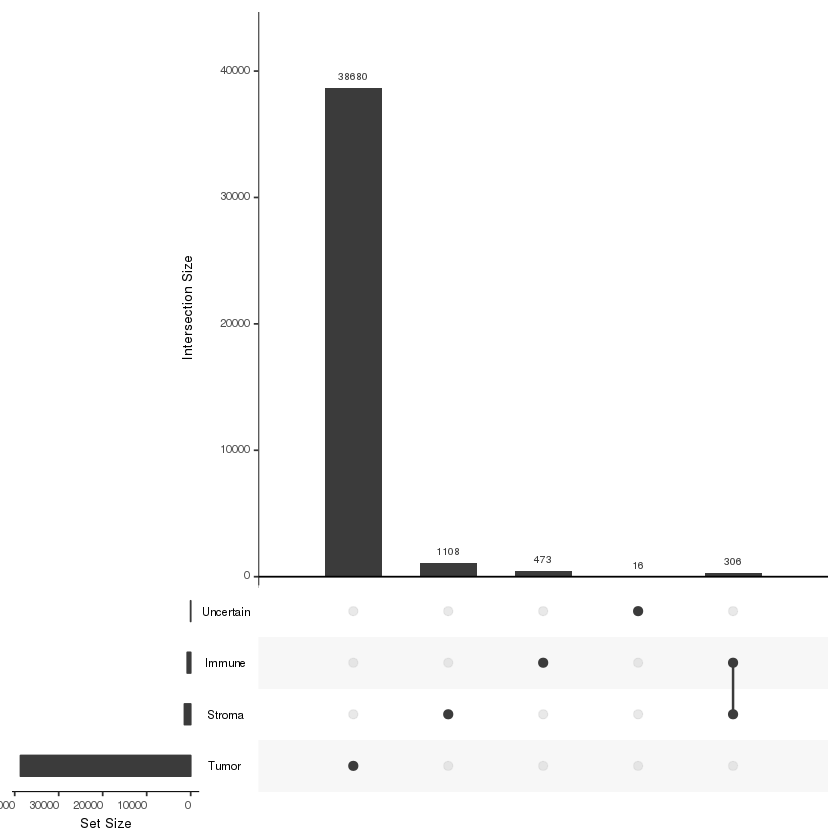

In [2]:
library(UpSetR)

switches %>%
    .$Origin %>%
    table %>%
    fromExpression(.) %>%
    upset

We cannot link an artifactual origin to most of the switches.

Loading required package: RColorBrewer


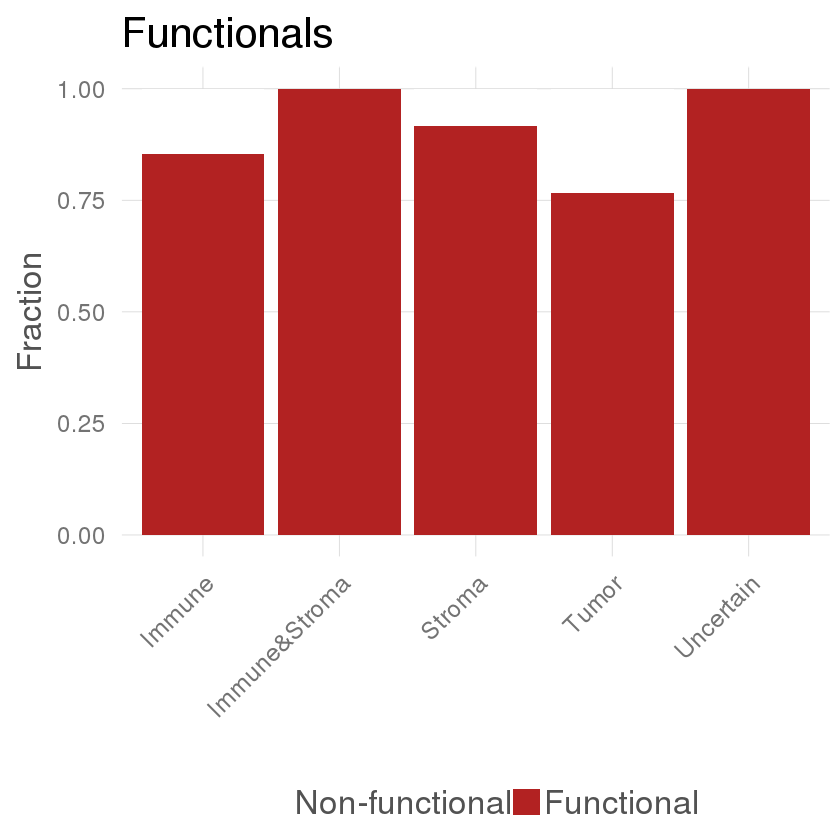

In [3]:
switches %>%
    mutate(IsFunctional = ifelse(IsFunctional==1, "Functional", "Non-functional"),
           IsFunctional = factor(IsFunctional, levels = c("Non-functional","Functional"))) %>%
ggplot(aes(x=Origin, fill=IsFunctional)) +
    geom_bar(position="fill") +
    labs(x="", y="Fraction", fill="", title="Functionals") +
    clean_theme() +
    theme(legend.position="bottom", axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_fill_manual(values = c("Functional"="firebrick", "Non-functional"="white"))

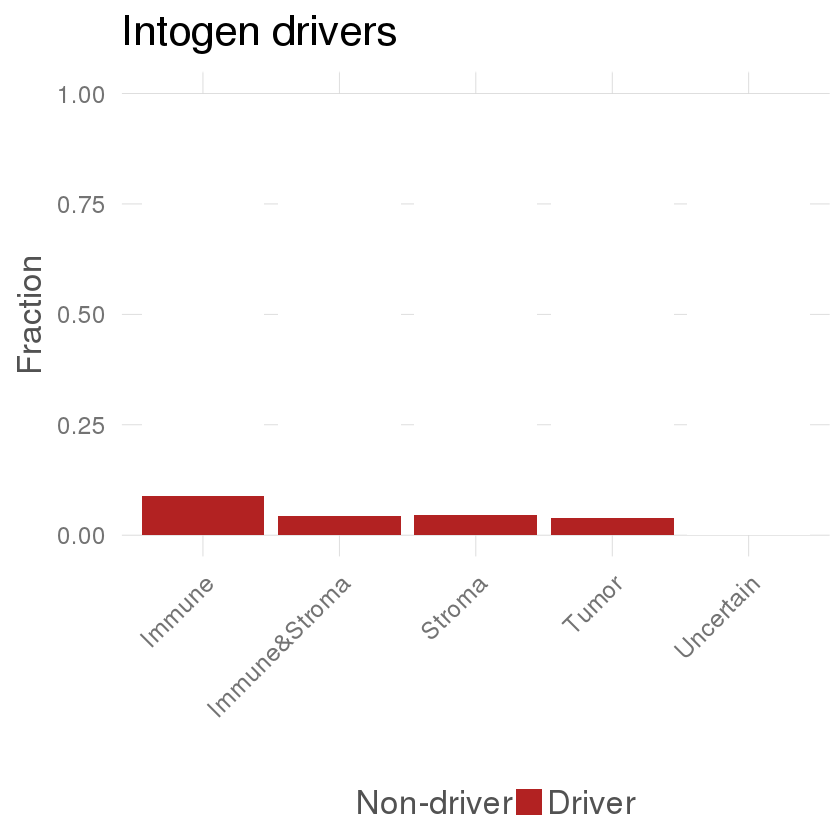

In [4]:
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  set_colnames(c("Symbol","Tumor"))

switches %>%
    mutate(Driver = ifelse(Driver==1, "Driver", "Non-driver"),
           Driver = factor(Driver, levels = c("Non-driver","Driver"))) %>%
    ggplot(aes(x=Origin, fill=Driver)) +
        geom_bar(position="fill") +
        labs(x="", y="Fraction" , fill="", title="Intogen drivers") +
        clean_theme() +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_fill_manual(values = c("Driver"="firebrick", "Non-driver"="white"))

The proportion of drivers affected are similar across categories, albeit unexpectedly lower in Tumor switches.

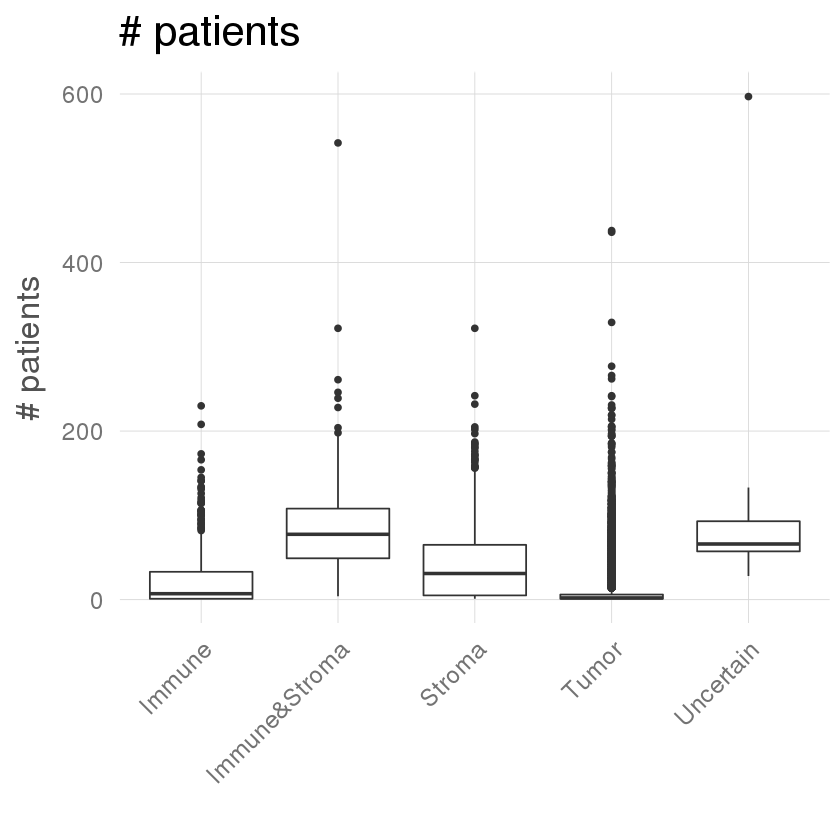

In [5]:
ggplot(switches, aes(x=Origin, y=PatientNumber)) +
    geom_boxplot() +
    labs(x="", y="# patients", title="# patients") +
    clean_theme() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

The non-tumor switches are more recurrent. That makes sense, as they are common to many patients with wt tissues (ie likely patient with high immune infiltration will have the switch detected). Also, Tumor category includes many switches that whose recurrence is too low.

# Intersection with PoTuS

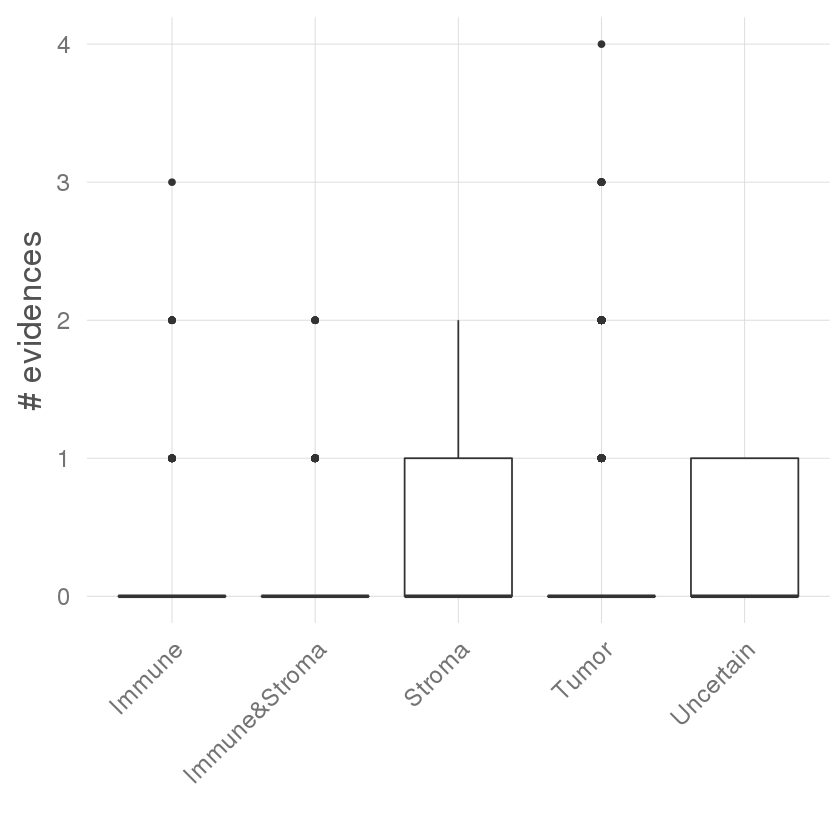

In [6]:
switches %>%
    filter(IsFunctional==1) %>%
    mutate(ASDriver = Recurrence+Affects_mutated_feature+PPI+as.logical(Pannegative)) %>%
    ggplot(aes(x = Origin, y = ASDriver)) +
        geom_boxplot() +
        labs(x="", y="# evidences") +
        clean_theme() + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

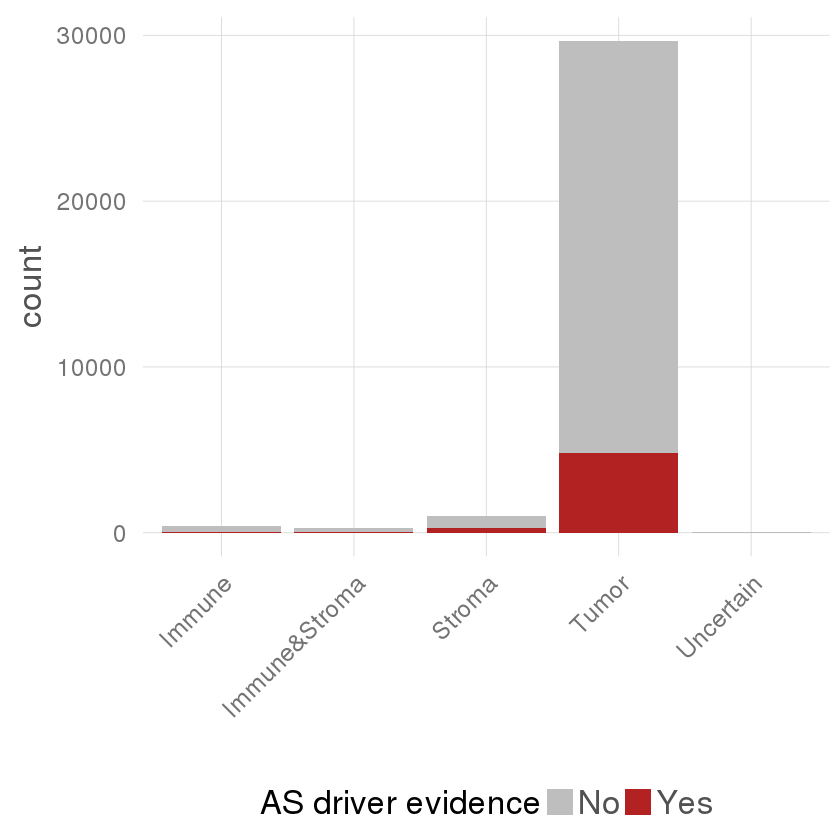

In [7]:
switches %>%
    filter(IsFunctional==1) %>%
    mutate( Candidate = ifelse(Candidate==1, "Yes", "No")) %>%
    ggplot(aes(x = Origin, fill = Candidate)) +
        geom_bar() +
        clean_theme() +
        labs(fill="AS driver evidence", x="") +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_fill_manual(values = c("Yes"="firebrick", "No"="grey"))

In [8]:
# number of candidates with unclear origin
switches %>%
    filter(IsFunctional==1 & Origin != "Tumor" & Candidate == 1) %>% 
    nrow

# total number of candidates
switches %>%
    filter(IsFunctional==1 & Candidate == 1) %>%
    nrow

[1] 399

[1] 5234

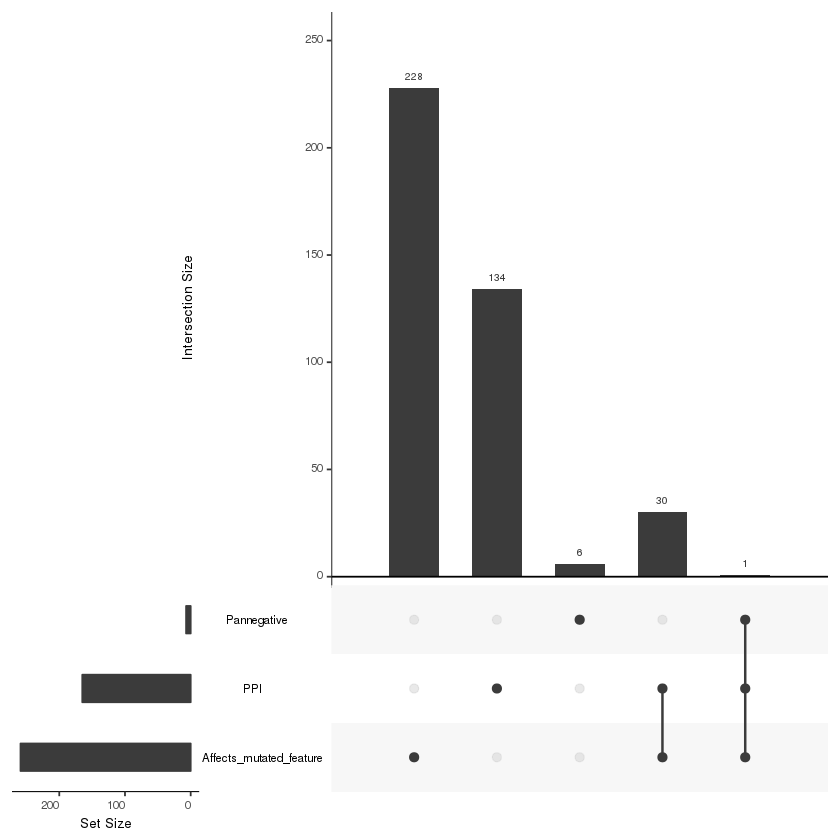

In [9]:
# explore how they affect each category
switches %>%
    filter(IsFunctional==1 & Candidate == 1 & Origin != "Tumor") %>%
    # Recurrence is excluded, as only Tumor switches are considered for recurrence calculation
    select(PPI:Pannegative) %>%
    mutate(Pannegative = ifelse(Pannegative > 0, 1, 0)) %>%
    as.data.frame %>%
    upset()